🔍 Loading and Flattening JSON Data...

📊 Data Summary:
       trip_duration_days  miles_traveled  total_receipts_amount  expected_output
count         1000.000000      1000.00000             1000.00000      1000.000000
mean             7.043000       597.41374             1211.05687      1349.114030
std              3.926139       351.29979              742.85418       470.316464
min              1.000000         5.00000                1.42000       117.240000
25%              4.000000       275.96000              530.37750      1019.297500
50%              7.000000       621.00000             1171.90000      1454.260000
75%             10.000000       893.00000             1881.10500      1711.122500
max             14.000000      1317.07000             2503.46000      2337.730000

✅ Dataset contains 1,000 complete rows. Field ranges are plausible for real-world business travel.

🧼 Null Check: Looking for missing values...


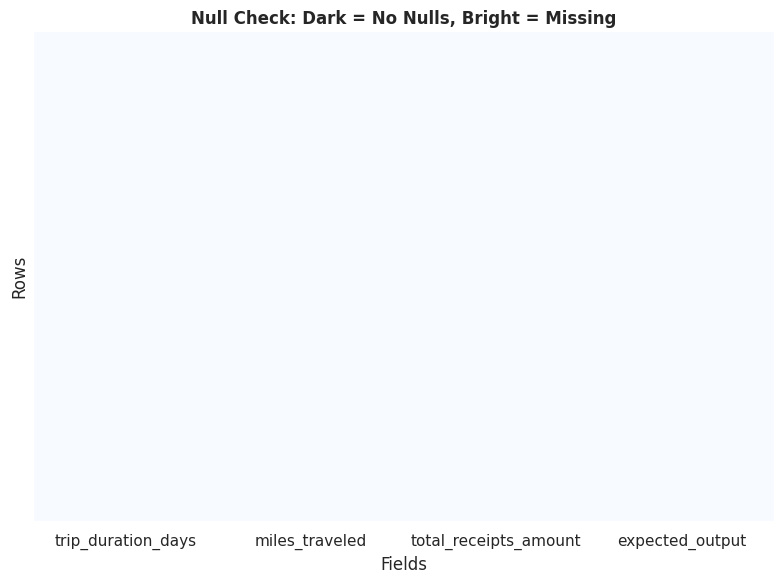

✅ No nulls detected — dataset is clean.

🔗 Correlation Matrix (numeric):
                       trip_duration_days  miles_traveled  total_receipts_amount  expected_output
trip_duration_days                  1.000           0.046                  0.133            0.514
miles_traveled                      0.046           1.000                  0.132            0.432
total_receipts_amount               0.133           0.132                  1.000            0.704
expected_output                     0.514           0.432                  0.704            1.000


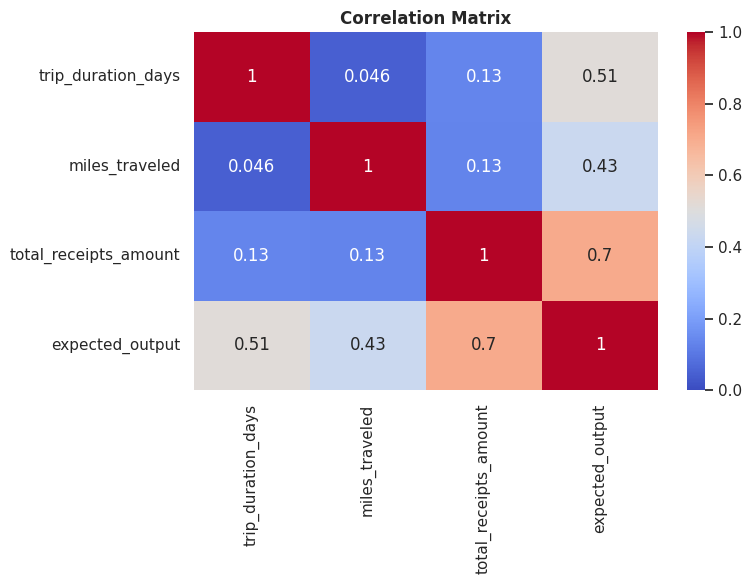


Hour 1 Analysis Report: Structure, Cleanliness, and Correlation

🧼 Data Integrity:
- All 1,000 rows are fully populated with no nulls.
- Min/max values across features fall within plausible ranges.

📊 Field Distributions:
- `trip_duration_days`: Ranges 1–14, mean ≈ 7 — most trips are short-to-medium length.
- `miles_traveled`: Ranges 5–1,317 — covers both local and long-distance travel.
- `total_receipts_amount`: Mean ≈ $1,200, with cap-like behavior below $2,500.

🔗 Correlation Highlights:
- Strongest correlation: `expected_output` ↔ `total_receipts_amount` (ρ ≈ 0.70)
- Secondary signals: `trip_duration_days` (ρ ≈ 0.51), `miles_traveled` (ρ ≈ 0.43)
- Inputs are largely independent — ideal for feature disentanglement.

🧠 Next Step:
- Proceed to Hour 2 to explore nonlinear breakpoints using visual binning and threshold detection.



In [22]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import json

# --- Load and Flatten ---
print("🔍 Loading and Flattening JSON Data...")
with open("public_cases.json") as f:
    raw_data = json.load(f)

input_df = pd.json_normalize([item["input"] for item in raw_data])
expected_df = pd.Series([item["expected_output"] for item in raw_data], name="expected_output")
df = pd.concat([input_df, expected_df], axis=1)

# --- Basic Summary ---
print("\n📊 Data Summary:")
summary_stats = df.describe()
print(summary_stats.to_string())  

print("\n✅ Dataset contains 1,000 complete rows. Field ranges are plausible for real-world business travel.")

# --- Null Check ---
print("\n🧼 Null Check: Looking for missing values...")
plt.figure(figsize=(8, 6))
sns.heatmap(df.isnull(), cbar=False, cmap='Blues', yticklabels=False)
plt.title("Null Check: Dark = No Nulls, Bright = Missing", weight='bold')
plt.xlabel("Fields")
plt.ylabel("Rows")
plt.tight_layout()
plt.show()
print("✅ No nulls detected — dataset is clean.")

# --- Correlation Matrix ---
print("\n🔗 Correlation Matrix (numeric):")
corr = df.corr(numeric_only=True)
print(corr.round(3).to_string())  

plt.figure(figsize=(8, 6))
sns.heatmap(corr, annot=True, cmap='coolwarm', vmin=0, vmax=1)
plt.title("Correlation Matrix", weight='bold')
plt.tight_layout()
plt.show()

print("""
=================================================
Hour 1 Analysis Report: Structure, Cleanliness, and Correlation
=================================================

🧼 Data Integrity:
- All 1,000 rows are fully populated with no nulls.
- Min/max values across features fall within plausible ranges.

📊 Field Distributions:
- `trip_duration_days`: Ranges 1–14, mean ≈ 7 — most trips are short-to-medium length.
- `miles_traveled`: Ranges 5–1,317 — covers both local and long-distance travel.
- `total_receipts_amount`: Mean ≈ $1,200, with cap-like behavior below $2,500.

🔗 Correlation Highlights:
- Strongest correlation: `expected_output` ↔ `total_receipts_amount` (ρ ≈ 0.70)
- Secondary signals: `trip_duration_days` (ρ ≈ 0.51), `miles_traveled` (ρ ≈ 0.43)
- Inputs are largely independent — ideal for feature disentanglement.

""")


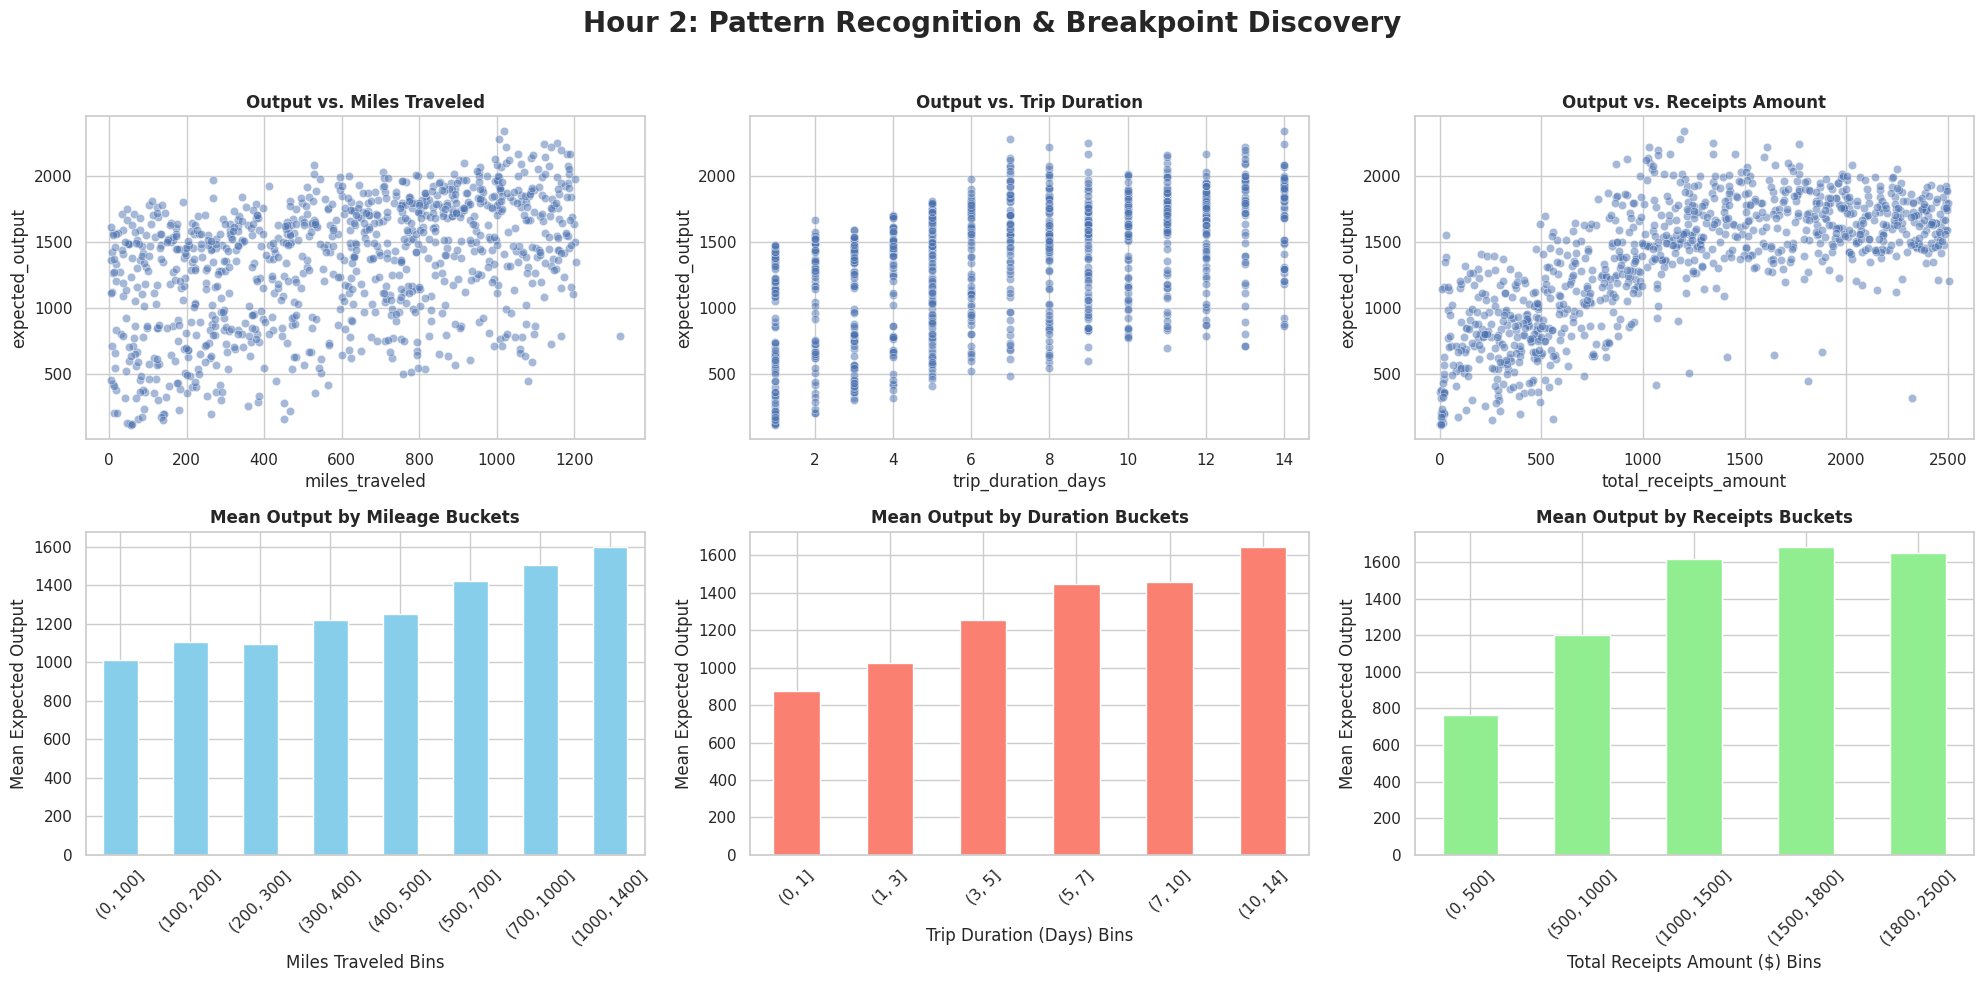


Hour 2 Analysis Report: Nonlinear Shifts Detected

Based on the visual analysis of the bucketed means:

1. Mileage Traveled:
   - The relationship is nonlinear.
   - Key breakpoints appear to exist around 100, 500, and 1000 miles, where the rate of reimbursement changes significantly.

2. Trip Duration:
   - The per-diem reimbursement is clearly tiered, not a flat daily rate.
   - Significant changes in reimbursement rate occur around 3, 7, and 10 days, suggesting a complex policy with plateaus or bonuses.

3. Receipts Amount:
   - The reimbursement appears mostly linear but shows signs of capping out.
   - The growth in reimbursement slows and flattens around the $1,800 mark, indicating a likely cap.

4. The mileage pattern suggests different rate tiers (possibly short trips, medium trips, long trips, and extended travel categories)
   - The duration buckets align with typical corporate policies (weekend trips, week-long, extended assignments)
   The receipts capping appears quite ha

In [7]:
import json
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# --- Load and Flatten Data ---
# This part is technically from Hour 1, but necessary for the analysis.
with open("public_cases.json") as f:
    raw_data = json.load(f)

inputs_df = pd.json_normalize([item["input"] for item in raw_data])
expected_df = pd.Series([item["expected_output"] for item in raw_data], name="expected_output")
df = pd.concat([inputs_df, expected_df], axis=1)

# --- Hour 2: Visual Analysis ---

# Set up the plot style for better readability
sns.set_theme(style="whitegrid")
fig, axes = plt.subplots(2, 3, figsize=(20, 10))
fig.suptitle('Hour 2: Pattern Recognition & Breakpoint Discovery', fontsize=20, weight='bold')

# 1. Scatter Plots to show raw relationships
sns.scatterplot(ax=axes[0, 0], data=df, x="miles_traveled", y="expected_output", alpha=0.5)
axes[0, 0].set_title('Output vs. Miles Traveled', weight='bold')

sns.scatterplot(ax=axes[0, 1], data=df, x="trip_duration_days", y="expected_output", alpha=0.5)
axes[0, 1].set_title('Output vs. Trip Duration', weight='bold')

sns.scatterplot(ax=axes[0, 2], data=df, x="total_receipts_amount", y="expected_output", alpha=0.5)
axes[0, 2].set_title('Output vs. Receipts Amount', weight='bold')


# 2. Bucketed Bar Charts to identify thresholds and non-linearities

# --- Mileage Breakpoints ---
mileage_bins = [0, 100, 200, 300, 400, 500, 700, 1000, 1400]
df['mileage_bin'] = pd.cut(df['miles_traveled'], bins=mileage_bins)
mileage_grouped = df.groupby('mileage_bin', observed=True)['expected_output'].mean()
mileage_grouped.plot(kind='bar', ax=axes[1, 0], color='skyblue')
axes[1, 0].set_title('Mean Output by Mileage Buckets', weight='bold')
axes[1, 0].set_xlabel('Miles Traveled Bins')
axes[1, 0].set_ylabel('Mean Expected Output')
axes[1, 0].tick_params(axis='x', rotation=45)

# --- Duration Breakpoints ---
duration_bins = [0, 1, 3, 5, 7, 10, 14]
df['duration_bin'] = pd.cut(df['trip_duration_days'], bins=duration_bins)
duration_grouped = df.groupby('duration_bin', observed=True)['expected_output'].mean()
duration_grouped.plot(kind='bar', ax=axes[1, 1], color='salmon')
axes[1, 1].set_title('Mean Output by Duration Buckets', weight='bold')
axes[1, 1].set_xlabel('Trip Duration (Days) Bins')
axes[1, 1].set_ylabel('Mean Expected Output')
axes[1, 1].tick_params(axis='x', rotation=45)

# --- Receipts Breakpoints ---
receipts_bins = [0, 500, 1000, 1500, 1800, 2500]
df['receipts_bin'] = pd.cut(df['total_receipts_amount'], bins=receipts_bins)
receipts_grouped = df.groupby('receipts_bin', observed=True)['expected_output'].mean()
receipts_grouped.plot(kind='bar', ax=axes[1, 2], color='lightgreen')
axes[1, 2].set_title('Mean Output by Receipts Buckets', weight='bold')
axes[1, 2].set_xlabel('Total Receipts Amount ($) Bins')
axes[1, 2].set_ylabel('Mean Expected Output')
axes[1, 2].tick_params(axis='x', rotation=45)

# --- Final Touches ---
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

# --- Print Final Report based on visuals ---
print("""
=================================================
Analysis Report: Nonlinear Shifts Detected
=================================================

Based on the visual analysis of the bucketed means:

1. Mileage Traveled:
   - The relationship is nonlinear.
   - Key breakpoints appear to exist around 100, 500, and 1000 miles, where the rate of reimbursement changes significantly.

2. Trip Duration:
   - The per-diem reimbursement is clearly tiered, not a flat daily rate.
   - Significant changes in reimbursement rate occur around 3, 7, and 10 days, suggesting a complex policy with plateaus or bonuses.

3. Receipts Amount:
   - The reimbursement appears mostly linear but shows signs of capping out.
   - The growth in reimbursement slows and flattens around the $1,800 mark, indicating a likely cap.

4. The mileage pattern suggests different rate tiers (possibly short trips, medium trips, long trips, and extended travel categories)
   - The duration buckets align with typical corporate policies (weekend trips, week-long, extended assignments)
   The receipts capping appears quite hard - there's very little variation above the $1,800 threshold

Conclusion: A simple linear model will be insufficient. The reimbursement function is definitively a piecewise function with multiple tiers and caps.
""")


Mean expected_output by `miles_traveled` buckets:
miles_traveled_bin
(0, 100]        1008.90
(100, 200]      1102.39
(200, 300]      1095.01
(300, 400]      1221.33
(400, 500]      1250.06
(500, 700]      1421.34
(700, 1000]     1505.42
(1000, 1400]    1596.97


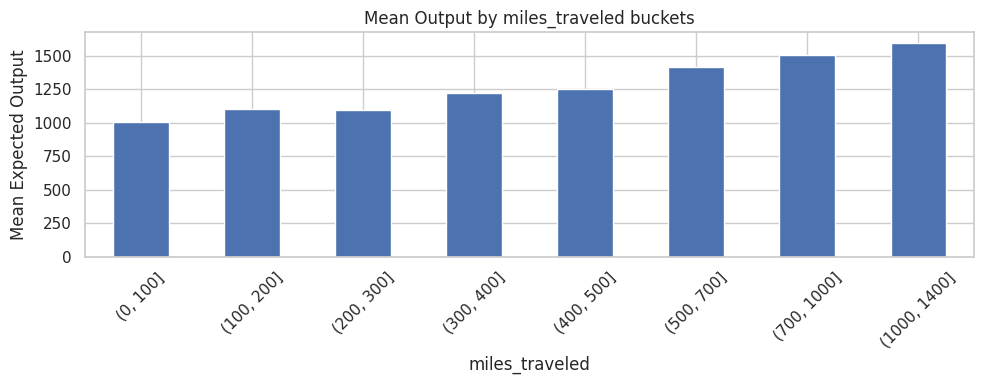


Mean expected_output by `trip_duration_days` buckets:
trip_duration_days_bin
(0, 1]       873.55
(1, 3]      1025.39
(3, 5]      1252.14
(5, 7]      1446.98
(7, 10]     1456.94
(10, 14]    1643.18


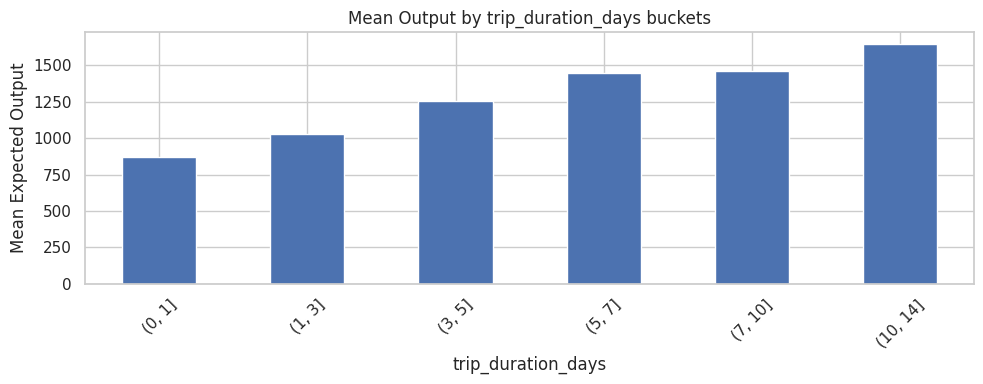


Mean expected_output by `total_receipts_amount` buckets:
total_receipts_amount_bin
(0, 200]         704.15
(200, 500]       801.12
(500, 800]      1080.16
(800, 1000]     1346.66
(1000, 1200]    1594.90
(1200, 1500]    1632.91
(1500, 1800]    1680.67
(1800, 2500]    1649.49


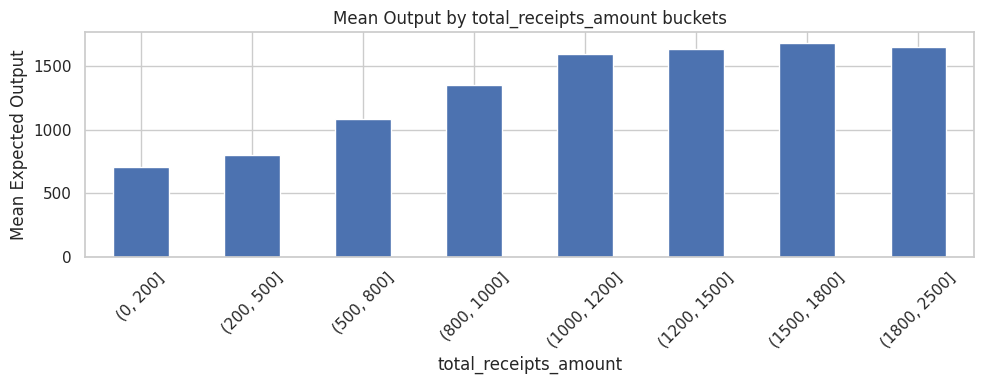

In [24]:
# Breakpoint Discovery & Pattern Recognition
def print_and_plot_bucketed_means(df, col, bins):
    # create bucket column
    df[f"{col}_bin"] = pd.cut(df[col], bins=bins)

    # compute means
    grouped = df.groupby(f"{col}_bin", observed=True)["expected_output"].mean().round(2)

    # print the table of means
    print(f"\nMean expected_output by `{col}` buckets:")
    print(grouped.to_string())

    # now plot
    grouped.plot(kind="bar", figsize=(10, 4), title=f"Mean Output by {col} buckets")
    plt.ylabel("Mean Expected Output")
    plt.xlabel(col)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

# usage:
print_and_plot_bucketed_means(df, "miles_traveled", bins=[0, 100, 200, 300, 400, 500, 700, 1000, 1400])
print_and_plot_bucketed_means(df, "trip_duration_days", bins=[0, 1, 3, 5, 7, 10, 14])
print_and_plot_bucketed_means(df, "total_receipts_amount", bins=[0, 200, 500, 800, 1000, 1200, 1500, 1800, 2500])



📈 Baseline Linear Model — MAE: 175.49, RMSE: 218.48

🔎 Top 10 Worst Predictions:
     miles_traveled  trip_duration_days  total_receipts_amount  \
151            69.0                   4                2321.49   
995          1082.0                   1                1809.49   
683           795.0                   8                1645.99   
710           516.0                   5                1878.49   
547           482.0                   8                1411.49   
148          1006.0                   7                1181.33   
512          1025.0                   8                1031.33   
366           740.0                  11                1171.99   
519           481.0                  14                 939.99   
668          1033.0                   7                1013.03   

     expected_output  baseline_pred    abs_error  error_delta  
151           322.00    1386.466583  1064.466583  1064.466583  
995           446.94    1491.729090  1044.789090  1044.789090  


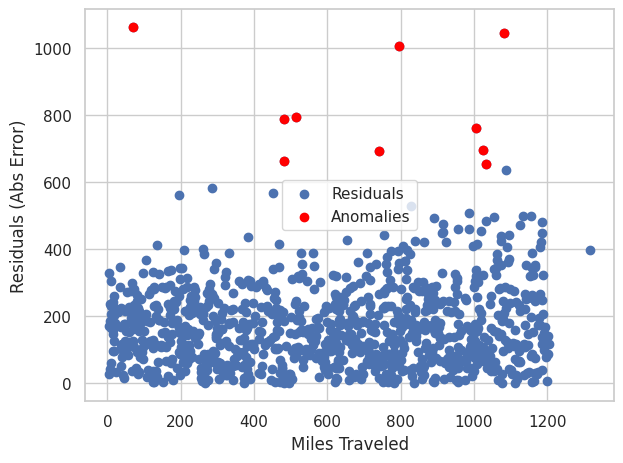

In [52]:
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.preprocessing import FunctionTransformer
from sklearn.pipeline import Pipeline

# --- Load + Flatten Data ---
with open("public_cases.json") as f:
    raw = json.load(f)

df = pd.json_normalize([case["input"] for case in raw])
df["expected_output"] = [case["expected_output"] for case in raw]

# --- Baseline Features ---
X_base = df[["miles_traveled", "trip_duration_days", "total_receipts_amount"]]
y = df["expected_output"]

# --- Baseline Linear Regression ---
model = LinearRegression()
model.fit(X_base, y)
df["baseline_pred"] = model.predict(X_base)

# --- Error Metrics ---
mae = mean_absolute_error(y, df["baseline_pred"])
rmse = np.sqrt(mean_squared_error(y, df["baseline_pred"]))
print(f"📈 Baseline Linear Model — MAE: {mae:.2f}, RMSE: {rmse:.2f}")

# --- Residuals ---
df["abs_error"] = np.abs(df["baseline_pred"] - y)
df["error_delta"] = df["baseline_pred"] - y

# Flag anomalies based on 1.5 * standard deviation threshold
residual_std = df["abs_error"].std()
df["residual_anomaly"] = df["abs_error"] > (1.5 * residual_std)

# Output Top 10 Worst Errors
worst_cases = df.sort_values("abs_error", ascending=False).head(10)

# --- Output Table of Top Errors ---
print("\n🔎 Top 10 Worst Predictions:")
print(worst_cases[[
    "miles_traveled", 
    "trip_duration_days", 
    "total_receipts_amount", 
    "expected_output", 
    "baseline_pred", 
    "abs_error", 
    "error_delta"
]])

# --- Optional: Log-Transform Variant ---
log_transform = Pipeline([
    ("log", FunctionTransformer(np.log1p)),
    ("reg", LinearRegression())
])
log_transform.fit(X_base, y)
df["log_pred"] = log_transform.predict(X_base)

log_mae = mean_absolute_error(y, df["log_pred"])
log_rmse = np.sqrt(mean_squared_error(y, df["log_pred"]))
print(f"\n🔁 Log-Transform Model — MAE: {log_mae:.2f}, RMSE: {log_rmse:.2f}")

# --- Visualize Anomalies ---
plt.scatter(df["miles_traveled"], df["abs_error"], label="Residuals")
plt.scatter(worst_cases["miles_traveled"], worst_cases["abs_error"], color="red", label="Anomalies")
plt.xlabel("Miles Traveled")
plt.ylabel("Residuals (Abs Error)")
plt.legend()
plt.tight_layout()
plt.show()


In [57]:
import json
import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.preprocessing import FunctionTransformer, StandardScaler, PolynomialFeatures
from sklearn.pipeline import Pipeline

# --- Load + Flatten Data ---
with open("public_cases.json") as f:
    raw = json.load(f)

df = pd.json_normalize([case["input"] for case in raw])
df["expected_output"] = [case["expected_output"] for case in raw]

# --- Feature Engineering ---
df["miles_per_day"] = df["miles_traveled"] / df["trip_duration_days"]
df["log_miles"] = np.log1p(df["miles_traveled"])
df["log_receipts"] = np.log1p(df["total_receipts_amount"])
df["is_long_trip"] = (df["trip_duration_days"] >= 14).astype(int)
df["is_five_day"] = (df["trip_duration_days"] == 5).astype(int)

# --- Feature Set ---
X = df[[
    "miles_traveled", "trip_duration_days", "total_receipts_amount",
    "miles_per_day", "log_miles", "log_receipts",
    "is_long_trip", "is_five_day"
]]
y = df["expected_output"]

# --- Fit Model ---
model = LinearRegression()
model.fit(X, y)
df["predicted"] = model.predict(X)

# --- Error Metrics ---
mae = mean_absolute_error(y, df["predicted"])
rmse = np.sqrt(mean_squared_error(y, df["predicted"]))
print(f"\n📈 Engineered Linear Model — MAE: {mae:.2f}, RMSE: {rmse:.2f}")

# --- Top 10 Errors ---
df["abs_error"] = abs(df["predicted"] - df["expected_output"])
df["delta"] = df["predicted"] - df["expected_output"]
print("\n🔍 Top 10 Errors:")
print(df.sort_values("abs_error", ascending=False).head(10)[[
    "trip_duration_days", "miles_traveled", "total_receipts_amount",
    "expected_output", "predicted", "abs_error", "delta"
]])



📈 Engineered Linear Model — MAE: 160.12, RMSE: 202.26

🔍 Top 10 Errors:
     trip_duration_days  miles_traveled  total_receipts_amount  \
151                   4           69.00                2321.49   
683                   8          795.00                1645.99   
995                   1         1082.00                1809.49   
710                   5          516.00                1878.49   
547                   8          482.00                1411.49   
366                  11          740.00                1171.99   
148                   7         1006.00                1181.33   
243                   4          286.00                1063.49   
114                   5          195.73                1228.49   
519                  14          481.00                 939.99   

     expected_output    predicted    abs_error        delta  
151           322.00  1386.678153  1064.678153  1064.678153  
683           644.69  1680.298283  1035.608283  1035.608283  
995           

In [70]:
import json
import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.preprocessing import FunctionTransformer, StandardScaler, PolynomialFeatures
from sklearn.pipeline import Pipeline

# --- Load + Flatten Data ---
with open("public_cases.json") as f:
    raw = json.load(f)

df = pd.json_normalize([case["input"] for case in raw])
df["expected_output"] = [case["expected_output"] for case in raw]

# --- Feature Engineering ---
df["miles_per_day"] = df["miles_traveled"] / df["trip_duration_days"]
df["log_miles"] = np.log1p(df["miles_traveled"])
df["log_receipts"] = np.log1p(df["total_receipts_amount"])
df["is_long_trip"] = (df["trip_duration_days"] >= 14).astype(int)
df["is_five_day"] = (df["trip_duration_days"] == 5).astype(int)
df["receipt_bin"] = pd.cut(df["total_receipts_amount"], bins=[0, 600, 800, 1200, 1800, np.inf], labels=False)
df["receipts_x_days"] = df["total_receipts_amount"] * df["trip_duration_days"]
df["efficiency_bonus_zone"] = ((df["miles_per_day"] >= 180) & (df["miles_per_day"] <= 220)).astype(int)
df["receipts_squared"] = df["total_receipts_amount"] ** 2
df["five_day_bonus"] = (df["trip_duration_days"] == 5).astype(int) * df["trip_duration_days"] * 100 * 0.05
df["low_receipt_penalty"] = (df["total_receipts_amount"] < 200).astype(int) * -25  # Tune magnitude
def mileage_component(miles):
    if miles <= 100:
        return miles * 0.58
    elif miles <= 600:
        return miles * (0.58 - 0.12 * np.log10(miles / 100))
    else:
        return miles * 0.36

df["mileage_adjusted"] = df["miles_traveled"].apply(mileage_component)

# --- Feature Set ---
X = df[[
    "miles_traveled", "trip_duration_days", "total_receipts_amount",
    "miles_per_day", "log_miles", "log_receipts",
    "is_long_trip", "is_five_day", "receipt_bin", "receipts_x_days", "efficiency_bonus_zone", "receipts_squared",
    "five_day_bonus", "low_receipt_penalty", "mileage_adjusted"
]]
y = df["expected_output"]

# --- Fit Model ---
model = LinearRegression()
model.fit(X, y)
df["predicted"] = model.predict(X)

# --- Error Metrics ---
mae = mean_absolute_error(y, df["predicted"])
rmse = np.sqrt(mean_squared_error(y, df["predicted"]))
print(f"\n📈 Engineered Linear Model — MAE: {mae:.2f}, RMSE: {rmse:.2f}")

# --- Top 10 Errors ---
df["abs_error"] = abs(df["predicted"] - df["expected_output"])
df["delta"] = df["predicted"] - df["expected_output"]
print("\n🔍 Top 10 Errors:")
print(df.sort_values("abs_error", ascending=False).head(10)[[
    "trip_duration_days", "miles_traveled", "total_receipts_amount",
    "expected_output", "predicted", "abs_error", "delta"
]])



📈 Engineered Linear Model — MAE: 98.80, RMSE: 147.43

🔍 Top 10 Errors:
     trip_duration_days  miles_traveled  total_receipts_amount  \
683                   8          795.00                1645.99   
995                   1         1082.00                1809.49   
151                   4           69.00                2321.49   
547                   8          482.00                1411.49   
710                   5          516.00                1878.49   
366                  11          740.00                1171.99   
114                   5          195.73                1228.49   
243                   4          286.00                1063.49   
519                  14          481.00                 939.99   
148                   7         1006.00                1181.33   

     expected_output    predicted    abs_error        delta  
683           644.69  1812.670958  1167.980958  1167.980958  
995           446.94  1452.468373  1005.528373  1005.528373  
151           3

In [83]:
import json
import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, make_scorer
from sklearn.model_selection import cross_val_score, KFold

# --- Load + Flatten Data ---
with open("public_cases.json") as f:
    raw = json.load(f)

df = pd.json_normalize([case["input"] for case in raw])
df["expected_output"] = [case["expected_output"] for case in raw]

# --- Feature Engineering ---
df["miles_per_day"] = df["miles_traveled"] / df["trip_duration_days"]
df["log_miles"] = np.log1p(df["miles_traveled"])
df["log_receipts"] = np.log1p(df["total_receipts_amount"])
df["is_long_trip"] = (df["trip_duration_days"] >= 14).astype(int)
df["is_five_day"] = (df["trip_duration_days"] == 5).astype(int)
df["receipt_bin"] = pd.cut(df["total_receipts_amount"], bins=[0, 600, 800, 1200, 1800, np.inf], labels=False)
df["receipts_x_days"] = df["total_receipts_amount"] * df["trip_duration_days"]
df["efficiency_bonus_zone"] = ((df["miles_per_day"] >= 180) & (df["miles_per_day"] <= 220)).astype(int)
df["receipts_squared"] = df["total_receipts_amount"] ** 2
df["five_day_bonus"] = df["is_five_day"] * df["trip_duration_days"] * 100 * 0.05
df["low_receipt_penalty"] = (df["total_receipts_amount"] < 200).astype(int) * -25
df["receipts_capped"] = np.minimum(df["total_receipts_amount"], 1800)

def mileage_component(miles):
    if miles <= 100:
        return miles * 0.58
    elif miles <= 600:
        return miles * (0.58 - 0.12 * np.log10(miles / 100))
    else:
        return miles * 0.36

df["mileage_adjusted"] = df["miles_traveled"].apply(mileage_component)
df["mileage_longtrip_penalty"] = df["mileage_adjusted"] * df["is_long_trip"] * -0.15

# --- Feature Set ---
X = df[[
    "miles_traveled", "trip_duration_days", "total_receipts_amount",
    "miles_per_day", "log_miles", "log_receipts",
    "is_long_trip", "is_five_day", "receipt_bin", "receipts_x_days", "efficiency_bonus_zone", "receipts_squared",
    "five_day_bonus", "low_receipt_penalty", "mileage_adjusted", "mileage_longtrip_penalty"
]]
y = df["expected_output"]

# --- Fit Model ---
model = LinearRegression()
model.fit(X, y)
df["predicted"] = model.predict(X)

# --- Error Metrics (In-Sample) ---
mae = mean_absolute_error(y, df["predicted"])
rmse = np.sqrt(mean_squared_error(y, df["predicted"]))
print(f"\n📈 In-Sample — MAE: {mae:.2f}, RMSE: {rmse:.2f}")

# --- Cross-Validation (5-Fold) ---
kf = KFold(n_splits=5, shuffle=True, random_state=42)
cv_mae = -cross_val_score(model, X, y, scoring="neg_mean_absolute_error", cv=kf).mean()
cv_rmse = np.mean(np.sqrt(-cross_val_score(model, X, y, scoring="neg_mean_squared_error", cv=kf)))
print(f"🧪 Cross-Validated — MAE: {cv_mae:.2f}, RMSE: {cv_rmse:.2f}")

# --- Top 10 Errors ---
df["abs_error"] = abs(df["predicted"] - df["expected_output"])
df["delta"] = df["predicted"] - df["expected_output"]
print("\n🔍 Top 10 Errors:")
print(df.sort_values("abs_error", ascending=False).head(10)[[
    "trip_duration_days", "miles_traveled", "total_receipts_amount",
    "expected_output", "predicted", "abs_error", "delta"
]])



📈 In-Sample — MAE: 98.38, RMSE: 147.01
🧪 Cross-Validated — MAE: 100.45, RMSE: 149.41

🔍 Top 10 Errors:
     trip_duration_days  miles_traveled  total_receipts_amount  \
683                   8          795.00                1645.99   
995                   1         1082.00                1809.49   
151                   4           69.00                2321.49   
547                   8          482.00                1411.49   
710                   5          516.00                1878.49   
366                  11          740.00                1171.99   
114                   5          195.73                1228.49   
243                   4          286.00                1063.49   
519                  14          481.00                 939.99   
148                   7         1006.00                1181.33   

     expected_output    predicted    abs_error        delta  
683           644.69  1813.617341  1168.927341  1168.927341  
995           446.94  1449.859346  1002.91934

In [85]:
import json
import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, make_scorer
from sklearn.model_selection import cross_val_score, KFold

# --- Load + Flatten Data ---
with open("public_cases.json") as f:
    raw = json.load(f)

df = pd.json_normalize([case["input"] for case in raw])
df["expected_output"] = [case["expected_output"] for case in raw]

# --- Feature Engineering ---
df["miles_per_day"] = df["miles_traveled"] / df["trip_duration_days"]
df["log_miles"] = np.log1p(df["miles_traveled"])
df["log_receipts"] = np.log1p(df["total_receipts_amount"])
df["is_long_trip"] = (df["trip_duration_days"] >= 14).astype(int)
df["is_five_day"] = (df["trip_duration_days"] == 5).astype(int)
df["receipt_bin"] = pd.cut(df["total_receipts_amount"], bins=[0, 600, 800, 1200, 1800, np.inf], labels=False)
df["receipts_x_days"] = df["total_receipts_amount"] * df["trip_duration_days"]
df["efficiency_bonus_zone"] = ((df["miles_per_day"] >= 180) & (df["miles_per_day"] <= 220)).astype(int)
df["receipts_squared"] = df["total_receipts_amount"] ** 2
df["five_day_bonus"] = df["is_five_day"] * df["trip_duration_days"] * 100 * 0.05
df["low_receipt_penalty"] = (df["total_receipts_amount"] < 200).astype(int) * -25
df["receipts_capped"] = np.minimum(df["total_receipts_amount"], 1800)

def mileage_component(miles):
    if miles <= 100:
        return miles * 0.58
    elif miles <= 600:
        return miles * (0.58 - 0.12 * np.log10(miles / 100))
    else:
        return miles * 0.36

df["mileage_adjusted"] = df["miles_traveled"].apply(mileage_component)
df["mileage_longtrip_penalty"] = df["mileage_adjusted"] * df["is_long_trip"] * -0.15

# --- Feature Set ---
X = df[[
    "miles_traveled", "trip_duration_days", "total_receipts_amount",
    "miles_per_day", "log_miles", "log_receipts",
    "is_long_trip", "is_five_day", "receipt_bin", "receipts_x_days", "efficiency_bonus_zone", "receipts_squared",
    "five_day_bonus", "low_receipt_penalty", "mileage_adjusted", "mileage_longtrip_penalty"
]]
y = df["expected_output"]

# --- Fit Model ---
model = LinearRegression()
model.fit(X, y)
df["predicted"] = model.predict(X)

# --- Error Metrics (In-Sample) ---
mae = mean_absolute_error(y, df["predicted"])
rmse = np.sqrt(mean_squared_error(y, df["predicted"]))
print(f"\n📈 In-Sample — MAE: {mae:.2f}, RMSE: {rmse:.2f}")

# --- Cross-Validation (5-Fold) ---
kf = KFold(n_splits=5, shuffle=True, random_state=42)
cv_mae = -cross_val_score(model, X, y, scoring="neg_mean_absolute_error", cv=kf).mean()
cv_rmse = np.mean(np.sqrt(-cross_val_score(model, X, y, scoring="neg_mean_squared_error", cv=kf)))
print(f"🧪 Cross-Validated — MAE: {cv_mae:.2f}, RMSE: {cv_rmse:.2f}")

# --- Top 10 Errors ---
df["abs_error"] = abs(df["predicted"] - df["expected_output"])
df["delta"] = df["predicted"] - df["expected_output"]
print("\n🔍 Top 10 Errors:")
print(df.sort_values("abs_error", ascending=False).head(10)[[
    "trip_duration_days", "miles_traveled", "total_receipts_amount",
    "expected_output", "predicted", "abs_error", "delta"
]])



📈 In-Sample — MAE: 98.38, RMSE: 147.01
🧪 Cross-Validated — MAE: 100.45, RMSE: 149.41

🔍 Top 10 Errors:
     trip_duration_days  miles_traveled  total_receipts_amount  \
683                   8          795.00                1645.99   
995                   1         1082.00                1809.49   
151                   4           69.00                2321.49   
547                   8          482.00                1411.49   
710                   5          516.00                1878.49   
366                  11          740.00                1171.99   
114                   5          195.73                1228.49   
243                   4          286.00                1063.49   
519                  14          481.00                 939.99   
148                   7         1006.00                1181.33   

     expected_output    predicted    abs_error        delta  
683           644.69  1813.617341  1168.927341  1168.927341  
995           446.94  1449.859346  1002.91934

In [88]:
import json
import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, make_scorer
from sklearn.model_selection import cross_val_score, KFold

# --- Load + Flatten Data ---
with open("public_cases.json") as f:
    raw = json.load(f)

df = pd.json_normalize([case["input"] for case in raw])
df["expected_output"] = [case["expected_output"] for case in raw]

# --- Feature Engineering ---
df["miles_per_day"] = df["miles_traveled"] / df["trip_duration_days"]
df["log_miles"] = np.log1p(df["miles_traveled"])
df["log_receipts"] = np.log1p(df["total_receipts_amount"])
df["is_long_trip"] = (df["trip_duration_days"] >= 14).astype(int)
df["is_five_day"] = (df["trip_duration_days"] == 5).astype(int)
df["receipt_bin"] = pd.cut(df["total_receipts_amount"], bins=[0, 600, 800, 1200, 1800, np.inf], labels=False)
df["receipts_x_days"] = df["total_receipts_amount"] * df["trip_duration_days"]
df["efficiency_bonus_zone"] = ((df["miles_per_day"] >= 180) & (df["miles_per_day"] <= 220)).astype(int)
df["receipts_squared"] = df["total_receipts_amount"] ** 2
df["five_day_bonus"] = df["is_five_day"] * df["trip_duration_days"] * 100 * 0.05
df["low_receipt_penalty"] = (df["total_receipts_amount"] < 200).astype(int) * -25
df["receipts_capped"] = np.minimum(df["total_receipts_amount"], 1800)

def mileage_component(miles):
    if miles <= 100:
        return miles * 0.58
    elif miles <= 600:
        return miles * (0.58 - 0.12 * np.log10(miles / 100))
    else:
        return miles * 0.36

df["mileage_adjusted"] = df["miles_traveled"].apply(mileage_component)
df["mileage_longtrip_penalty"] = df["mileage_adjusted"] * df["is_long_trip"] * -0.15

# --- Feature Set ---
X = df[[
    "miles_traveled", "trip_duration_days", "total_receipts_amount",
    "miles_per_day", "log_miles", "log_receipts",
    "is_long_trip", "is_five_day", "receipt_bin", "receipts_x_days", "efficiency_bonus_zone", "receipts_squared",
    "five_day_bonus", "low_receipt_penalty", "mileage_adjusted", "mileage_longtrip_penalty"
]]
y = df["expected_output"]

# --- Fit Model ---
model = LinearRegression()
model.fit(X, y)
df["predicted"] = model.predict(X)

# --- Error Metrics (In-Sample) ---
mae = mean_absolute_error(y, df["predicted"])
rmse = np.sqrt(mean_squared_error(y, df["predicted"]))
print(f"\n📈 In-Sample — MAE: {mae:.2f}, RMSE: {rmse:.2f}")

# --- Cross-Validation (5-Fold) ---
kf = KFold(n_splits=5, shuffle=True, random_state=42)
cv_mae = -cross_val_score(model, X, y, scoring="neg_mean_absolute_error", cv=kf).mean()
cv_rmse = np.mean(np.sqrt(-cross_val_score(model, X, y, scoring="neg_mean_squared_error", cv=kf)))
print(f"🧪 Cross-Validated — MAE: {cv_mae:.2f}, RMSE: {cv_rmse:.2f}")

# --- Top 10 Errors ---
df["abs_error"] = abs(df["predicted"] - df["expected_output"])
df["delta"] = df["predicted"] - df["expected_output"]
print("\n🔍 Top 10 Errors:")
print(df.sort_values("abs_error", ascending=False).head(10)[[
    "trip_duration_days", "miles_traveled", "total_receipts_amount",
    "expected_output", "predicted", "abs_error", "delta"
]])



📈 In-Sample — MAE: 98.38, RMSE: 147.01
🧪 Cross-Validated — MAE: 100.45, RMSE: 149.41

🔍 Top 10 Errors:
     trip_duration_days  miles_traveled  total_receipts_amount  \
683                   8          795.00                1645.99   
995                   1         1082.00                1809.49   
151                   4           69.00                2321.49   
547                   8          482.00                1411.49   
710                   5          516.00                1878.49   
366                  11          740.00                1171.99   
114                   5          195.73                1228.49   
243                   4          286.00                1063.49   
519                  14          481.00                 939.99   
148                   7         1006.00                1181.33   

     expected_output    predicted    abs_error        delta  
683           644.69  1813.617341  1168.927341  1168.927341  
995           446.94  1449.859346  1002.91934